In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import copy, deepcopy

In [60]:
def show_pair(L, R):
    fig = plt.figure(figsize=(20,20))

    fig.add_subplot(1, 2, 1)
    plt.imshow(L[:, : ,::-1])
    plt.axis("off")
    fig.add_subplot(1, 2, 2)
    plt.imshow(R[:, :, ::-1])
    plt.axis("off")
    plt.subplots_adjust(wspace=0.01, hspace=0)
    plt.show()

# Calibration

## The files pts2d-pic_a.txt and pts3d.txt are a list of twenty 2D and 3D points of the image pic_a.jpg. The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation is: <br> 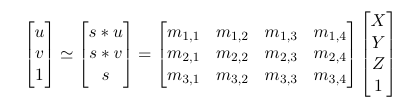 <br> Recall you solve for the 3x4 matrix M using either SVD to solve the homogeneous version of the equations or by setting m3,4 to 1 and then using the a normal least squares method. Remember that M is only known up to a scale factor. <br> To make sure that your code is correct, we are going to give you a set of “normalized points” in the files pts2d-norm-pic_a.txt and pts3d-norm.txt. If you solve for M using all the points you should get a matrix that is a scaled equivalent of the following: <br> 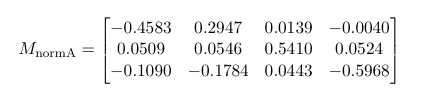 <br> For example, this matrix will take the last normalized 3D point which is < 1.2323, 1.4421, 0.4506, 1.0 > and will project it to the < u, v > of < 0.1419, −0.4518 > where we converted the homogeneous 2D point < us, vs, s > to its inhomogeneous version by dividing by s (i.e. the real transformed pixel in the image).


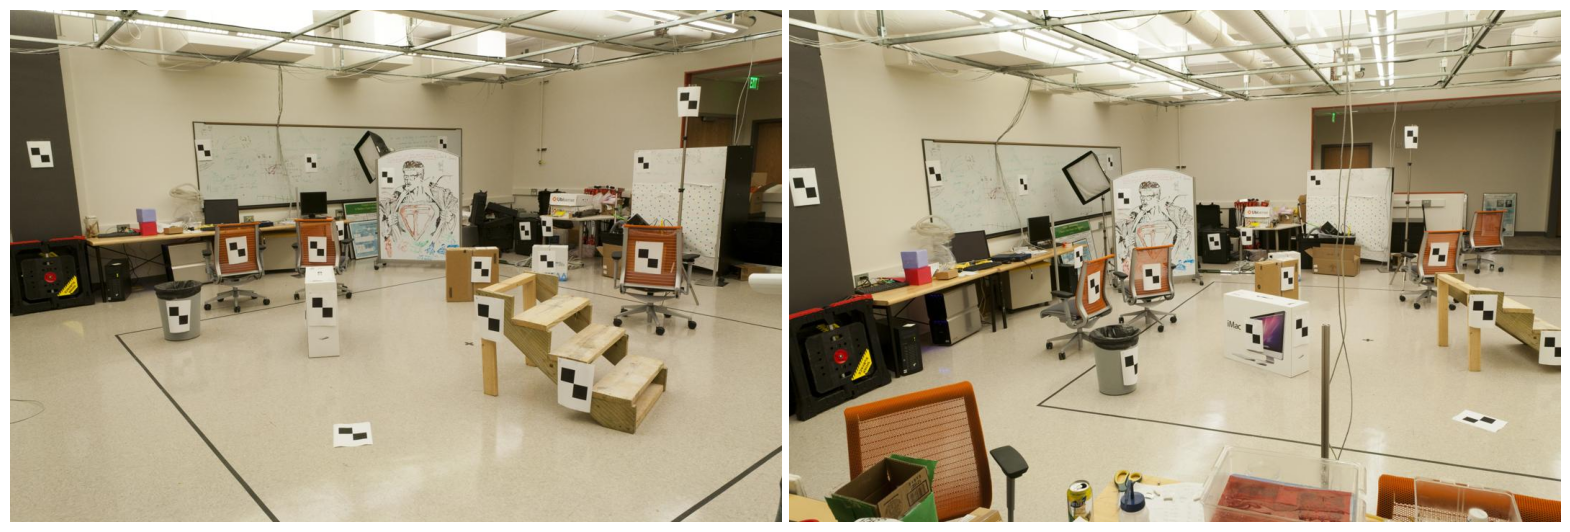

In [61]:
pic_a = cv2.imread('./input/pic_a.jpg')
pic_b = cv2.imread('./input/pic_b.jpg')
show_pair(pic_a, pic_b)

## Create the least squares function that will solve for the 3x4 matrix MnormA  given the normalized 2D and 3D lists, namely pts2d-norm-pic_a.txt and pts3d-norm.txt. Test it on the normalized 3D points by multiplying those points by your M matrix and comparing the resulting the normalized 2D points to the normalized 2D points given in the file. Remember to divide by the homogeneous value to get an inhomogeneous point. You can do the comparison by checking the residual between the predicted location of each test point using your equation and the actual location given by the 2D input data. The residual is just the distance (square root of the sum of squared differences in u and v).

In [62]:
def compute_M(pts2d, pts3d):

    size = pts2d.shape[0]
    ones, zeros = np.ones(shape=(size, )), np.zeros(shape=(size, ))

    x ,y = pts2d[:, 0], pts2d[:, 1]
    X, Y, Z = pts3d[:, 0], pts3d[:, 1], pts3d[:, 2]
    A = np.zeros((2*size, 12))
    A[::2] = np.stack([X, Y, Z, ones, zeros, zeros, zeros, zeros, -x*X, -x*Y, -x*Z, -x], axis=1)
    A[1::2] = np.stack([zeros, zeros, zeros, zeros, X, Y, Z, ones, -y*X, -y*Y, -y*Z, -y], axis=1)
    m = np.linalg.svd(A)[2][-1, :].reshape((3, -1))

    return m

In [63]:
def predict(pts2d, pts3d, M):
    size = pts2d.shape[0]
    pts3d_to_test = np.c_[ pts3d, np.ones((size, )) ] 
    MxP = np.dot(M, pts3d_to_test.T)
    pred = (MxP[:2, :]/MxP[2, :]).T
    return pred

In [64]:
def ls_error(pts2d, pts3d, M):
    pred = predict(pts2d, pts3d, M)    
    error = np.sum(np.square(pts2d - pred))
    return error
    

In [65]:
pts2d_norm = np.loadtxt('./input/pts2d-norm-pic_a.txt')
pts3d_norm = np.loadtxt('./input/pts3d-norm.txt')

M = compute_M(pts2d_norm, pts3d_norm)
error = ls_error(pts2d_norm, pts3d_norm, M) 

In [66]:
M, error

(array([[ 0.45827554, -0.29474237, -0.01395746,  0.0040258 ],
        [-0.05085589, -0.0545847 , -0.54105993, -0.05237592],
        [ 0.10900958,  0.17834548, -0.04426782,  0.5968205 ]]),
 0.00016877578217196286)

## Now you are ready to calibrate the camera. Using the 3D and 2D point lists for the image, we’re going to compute the camera projection matrix. To understand the effects of over constraining the system, you’re going to try using sets of 8, 12 and 16 points and then look at the residuals. To debug your code you can use the normalized set from above but for the actual question you’ll need to use: pts2d-pic_b.txt and pts3d.txt


In [67]:
pts2d_pic_a = np.loadtxt('./input/pts2d-pic_a.txt')
pts2d_pic_b = np.loadtxt('./input/pts2d-pic_b.txt')
pts3d= np.loadtxt('./input/pts3d.txt')

In [68]:
np.random.choice(20, 8, replace=False)

array([ 3,  1, 11,  0,  7, 19, 16, 13])

In [69]:
def test(num_points, pts2d, pts3d):
    best_m = []
    e = []
    for n in num_points:
        errors = []
        ms = []
        for i in range (10):
            pts_idxs = np.random.choice(pts2d.shape[0], n, replace=False)
            pts2d_sampled_n = pts2d[pts_idxs]
            pts3d_sampled_n = pts3d[pts_idxs]
            M = compute_M(pts2d_sampled_n, pts3d_sampled_n)
            pts2d_test_idxs = pts3d_test_idxs = [i for i in np.arange(0,20) if i not in pts_idxs][:4]
            error = ls_error(pts2d[pts2d_test_idxs], pts3d[pts3d_test_idxs], M)
            errors.append(error)
            ms.append(M)
        best_m.append(ms[np.argmin(errors)])
        e.append(min(errors))
    return best_m[np.argmin(e)], e

num_points = [8, 12, 16]
m, errors = test(num_points, pts2d_pic_b, pts3d)
print(errors)


[17.61813819575618, 4.180809193744441, 1.422338123337365]


In [70]:
m

array([[ 6.92836824e-03, -4.01198615e-03, -1.34318869e-03,
        -8.26717945e-01],
       [ 1.54892037e-03,  1.02378314e-03, -7.28045857e-03,
        -5.62497649e-01],
       [ 7.60928586e-06,  3.71208112e-06, -1.92528552e-06,
        -3.38812897e-03]])

## Finally we can solve for the camera center in the world. 


In [71]:
Q = m[:3, :3]
m4 = m[:, 3]
C = np.dot(-np.linalg.inv(Q), m4)

## To debug your code: If you use you the normalized 3D points to get the MnormA given above you would get a camera center of:<br>CnormA = <-1.5125, -2.3515, 0.2826>

In [72]:
m_norm = compute_M(pts2d_norm, pts3d_norm)
Q_norm = m_norm[:3, :3]
m4_norm = m_norm[:, 3]
C_norm = np.dot(-np.linalg.inv(Q_norm), m4_norm)
C_norm

array([-1.51267725, -2.35168754,  0.28262819])

## The location of the camera in real 3D world coordinates:

In [73]:
C 

array([303.10276725, 307.18671281,  30.42074599])

# Fundamental Matrix Estimation <br> 

## We now wish to estimate the mapping of points in one image to lines in another by means of the fundamental matrix. This will require you to use similar methods to those in question 1. We will make use of the corresponding point locations listed in pts2d-pic_a.txt and pts2d-pic_b.txt.

In [74]:
pts2d_pic_a = np.loadtxt('./input/pts2d-pic_a.txt')
pts2d_pic_b = np.loadtxt('./input/pts2d-pic_b.txt')

In [75]:
def compute_F(pts2d_a, pts2d_b):
    ul = pts2d_a[:, 0]
    vl = pts2d_a[:, 1]
    ur = pts2d_b[:, 0]
    vr = pts2d_b[:, 1]
    ones = np.ones(shape=(ul.shape[0], ))
    A = np.column_stack((ul*ur, ul*vr, ul, vl*ur, vl*vr, vl, ur, vr, ones))
    F = np.linalg.svd(A)[2][-1, :].reshape((3, 3))
    return F

In [76]:
F = compute_F(pts2d_pic_a, pts2d_pic_b)
F

array([[-6.60698417e-07,  8.82396296e-06, -9.07382302e-04],
       [ 7.91031621e-06,  1.21382933e-06, -2.64234650e-02],
       [-1.88600198e-03,  1.72332901e-02,  9.99500092e-01]])

## The linear squares estimate of is full rank; however, the fundamental matrix is a rank 2 matrix. As such we must reduce its rank. In order to do this we can decompose using singular value decomposition . We can then estimate a rank 2 matrix by setting the smallest singular value in E to zero thus generating E\`. The fundamental matrix is then easily calculated as UE\`V.T. 

In [77]:
def reduce_F(F):
    U, E, VT = np.linalg.svd(F)
    E[-1] = 0
    F_reduced = np.dot(U, np.dot(np.diag(E),VT))
    return F_reduced
    
F_reduced = reduce_F(F)
F_reduced

array([[-5.36264198e-07,  8.83539184e-06, -9.07382264e-04],
       [ 7.90364771e-06,  1.21321685e-06, -2.64234650e-02],
       [-1.88600204e-03,  1.72332901e-02,  9.99500092e-01]])

Now you can use your matrix  to estimate an epipolar line  in image ‘b’ corresponding to point  in image ‘a’:  

Similarly, epipolar lines in image a corresponding to points in image b are related by the transpose of F.

Draw these epipolar lines. Below is one way; the key is to be able to take the projective geometry form of the line and draw it in the image:
- The resulting lines defined in homogeneous coordinates can not be drawn directly using standard line functions, which take as input two points. In order to use such functions, we can find the intersection of a given line  with the image boundaries.
- If we define  to be the line corresponding to the left hand side of the image and  to be the line corresponding to the right hand side of the image, we can find the points  and . We can now plot the line running through the points , .
- However, we must first have the equations for   and . Making use of the point-line duality, we know, e.g., . Where  is the point defining the upper left-hand corner of the image and   is the bottom left-hand corner of the image.


In [78]:
def compute_epilines(F, pts2d_pic_a, pts2d_pic_b):
    elines_a = np.dot(F, np.c_[pts2d_pic_b, np.ones((pts2d_pic_b.shape[0], ))].T).T
    elines_b = np.dot(F.T, np.c_[pts2d_pic_a, np.ones((pts2d_pic_a.shape[0], ))].T).T
    return elines_a/elines_a[:, 2].reshape(-1, 1), elines_b/elines_b[:, 2].reshape(-1, 1)

In [79]:
elines_a, elines_b = compute_epilines(F_reduced, pts2d_pic_a, pts2d_pic_b)

In [80]:
elines_a

array([[ 2.15839630e-04, -5.46888982e-03,  1.00000000e+00],
       [ 2.43125032e-04, -4.95974418e-03,  1.00000000e+00],
       [ 2.21771189e-04, -5.35820692e-03,  1.00000000e+00],
       [ 3.14066351e-04, -3.63597903e-03,  1.00000000e+00],
       [ 2.94243330e-04, -4.00587664e-03,  1.00000000e+00],
       [ 7.93252535e-05, -8.01624833e-03,  1.00000000e+00],
       [ 4.01398865e-04, -2.00635418e-03,  1.00000000e+00],
       [ 2.33886206e-04, -5.13214068e-03,  1.00000000e+00],
       [ 3.32154328e-04, -3.29845736e-03,  1.00000000e+00],
       [ 3.77115167e-04, -2.45948803e-03,  1.00000000e+00],
       [ 3.72039692e-04, -2.55419639e-03,  1.00000000e+00],
       [ 3.55769677e-04, -2.85779491e-03,  1.00000000e+00],
       [ 3.30022423e-04, -3.33823871e-03,  1.00000000e+00],
       [ 3.26512556e-04, -3.40373284e-03,  1.00000000e+00],
       [ 3.61879585e-04, -2.74378400e-03,  1.00000000e+00],
       [ 3.21949364e-04, -3.48888200e-03,  1.00000000e+00],
       [ 3.60375264e-04, -2.77185463e-03

In [81]:
a_image = cv2.imread('./input/pic_a.jpg')
b_image = cv2.imread('./input/pic_b.jpg')
h, w, _ = a_image.shape

In [82]:
def compute_P(elines, h, w):
    _line_L = np.cross(np.array([0, 0, 1]), np.array([0, h, 1]))
    _line_R = np.cross(np.array([w, 0, 1]), np.array([w, h, 1]))
    P_L = np.cross(elines, _line_L)
    P_R = np.cross(elines, _line_R)

    P_L = (P_L/P_L[:, 2].reshape(-1, 1))[:, :2]
    P_R = (P_R/P_R[:, 2].reshape(-1, 1))[:, :2]

    return P_L, P_R

In [83]:
def draw_lines(image, elines, h ,w):
    P_L, P_R = compute_P(elines, h, w)
    for left, right in zip(P_L, P_R):
        cv2.line(image, tuple(left.astype(int)), tuple(right.astype(int)), (255,255,0), thickness=2)

In [84]:
draw_lines(a_image, elines_a, h, w)
draw_lines(b_image, elines_b, h, w)

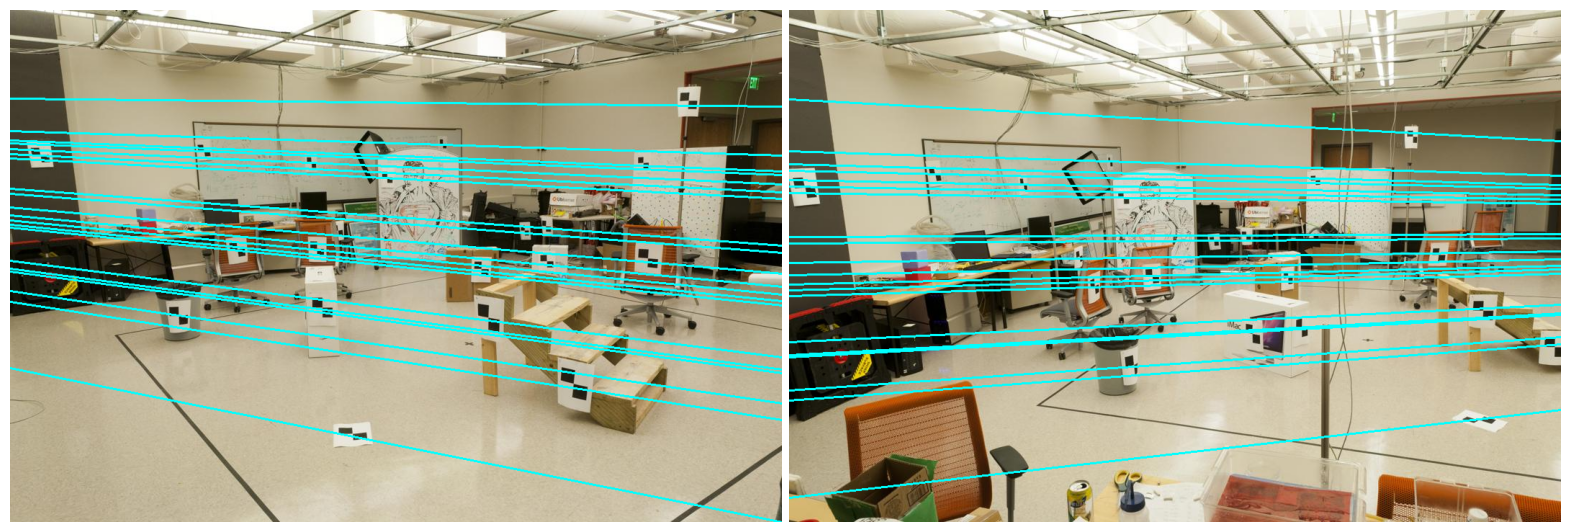

In [85]:
show_pair(a_image, b_image)

# EXTRA CREDIT PROBLEMS (2-d and 2-e)<br>If you look at the results of the last section the epipolar lines are close, but not perfect. The problem is that the offset and scale of the points is large and biased compared to some of the constants. To fix this, we are going to normalize the points.

In [86]:
def compute_C(pts2d):
    c = np.mean(pts2d, axis=0)
    c_matrix = np.array([[1, 0, -c[0]], [0, 1, -c[1]], [0, 0, 1]])
    return c_matrix

def compute_S(pts2d):  
    s = 1/pts2d.max()
    s_matrix = np.diag([s, s, 1])
    return s_matrix

def compute_T(pts2d):
    c = compute_C(pts2d)
    s = compute_S(pts2d)
    T = np.dot(s, c)
    return T

def normalize_points(pts2d, T):
    pts2d = np.c_[pts2d, np.ones((pts2d.shape[0], ))]
    pts2d = np.dot(T, pts2d.T).T
    return pts2d[:, :2]/pts2d[:, 2].reshape(-1, 1)



In [87]:
pts2d_pic_a = np.loadtxt('./input/pts2d-pic_a.txt')
pts2d_pic_b = np.loadtxt('./input/pts2d-pic_b.txt')

Ta = compute_T(pts2d_pic_a)
Tb = compute_T(pts2d_pic_b)

pts2d_pic_a_norm = normalize_points(pts2d_pic_a, Ta)
pts2d_pic_b_norm = normalize_points(pts2d_pic_b, Tb)

F = compute_F(pts2d_pic_a_norm, pts2d_pic_b_norm)
F_reduced = reduce_F(F)
better_F = np.dot(np.dot(Tb.T, F_reduced.T), Ta).T


In [88]:
elines_a, elines_b = compute_epilines(better_F, pts2d_pic_a, pts2d_pic_b)

In [89]:
a_image = cv2.imread('./input/pic_a.jpg')
b_image = cv2.imread('./input/pic_b.jpg')
h, w, _ = a_image.shape

In [90]:
draw_lines(a_image, elines_a, h, w)
draw_lines(b_image, elines_b, h, w)

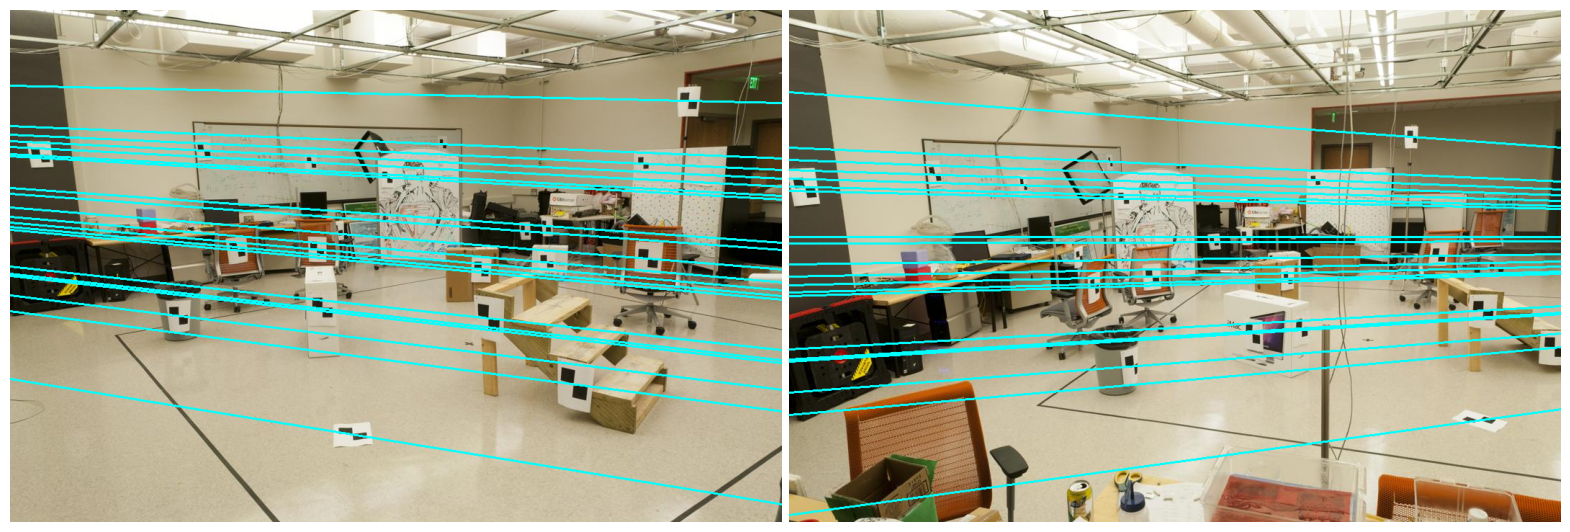

In [91]:
show_pair(a_image, b_image)